# What can affect how you rate a beer?

When we taste a beer and rate it we might think that our rating is based solely on how much we liked or disliked the beer. <br> However what we might not realize is that we may not be completely rational when it comes to our most liked or disliked beers/breweries, and we might rate them the way we do because of underlying intrinsic and extrinsic factors that we are not consciously aware of.
For instance you might really like Pale Ale because it was the first beer you tried in college in the US, but maybe if you had went to college in Germany your palate would've been more accustomed to Lager and you would've rated it better than Pale Ale style beers.<br>
With this project we wanted to dig deeper into the ratings and reviews given by users to highlight factors that might create a conscious or subconscious bias to how you rate a beer. However the list of such biases is unlimited, so we decided to focus on 3 main biases that could affect how you construct your opinion and explored how they do so. To us, those were some of the most important ones that could be done given the data we have. <br>
So without further ado, here's a data exploration of how your senses, location and political events you country might've witnessed can shape the way you rate a beer.

We are interested in the factors that define how much we like a beer. <br>
The goal is to investigate how important are intrinsic and extrinsic factors. <br>
For the intrinsic features we can make use of the ratings of different sensory aspects. <br>
For extrinsic influences it was a bit more difficult. We decided to look at the proximity to the brewery. <br>
Possibly a local beer could trigger a feeling of pride or affiliation, leading to a higher opinion. <br>

As another external factor we try to investigate economic factors. <br>
To do that we take a closer look at the financial crisis in 2007/2008.

## Table of Contents
- [Imports and paths](#imports)
- [Data extraction](#dataextraction)
    - [BeerAdvocate data](#beeradvocate)
    - [RateBeer data](#ratebeer)
    - [Matched data](#matched_data)
- [Data description](#datadescription)
    - [Beers](#beer_data)
    - [Breweries](#brewery_data)
    - [Users](#users)
    - [Reviews](#reviews)
- [Data pre-processing](#data_preprocessing)
    - [Users](#users_processing)
    - [Breweries](#breweries_processing)
    - [Reviews](reviews_processing)
- [Data exploration](#data_exploration)
- [Sensorial evaluation](#sensory)
- [Location bias](#location)
- [Political/Economic climate effect](#political)
- [Chapter 3](#chapter_3)
    - [Section 3.1](#section_3_1)
        - [Sub Section 3.1.1](#sub_section_3_1_1)
        - [Sub Section 3.1.2](#sub_section_3_1_2)
    - [Section 3.2](#section_3_2)
        - [Sub Section 3.2.1](#sub_section_3_2_1)
        - [Sub Section 3.2.2](#sub_section_3_2_2)

## Imports and paths<a class="anchor" id="imports"></a>

In [94]:
#reading data
import gzip #to read gzip files

#manipulating data 
import pandas as pd
import numpy as np
import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#serializing data
import pickle

#statistics
from scipy.stats import linregress

#for machine learning algorithms 
import torch

#set the seed for reproducibility 
np.random.seed(4)

In [4]:
PATH = '../'
DATA_PATH = './data/' 
DEFAULT_ENCODING = 'UTF8'
DEFAULT_COMPRESSION = 'gzip'

## Data extraction <a class="anchor" id="dataextraction"></a>

We start by extracting the data for beers, breweries and users from the two rating websites BeerAdvocate and RateBeer as well as the matched data. <br>
We view the dataframe first few rows to get a firt glance at what the data contains before pre-processing it:

### BeerAdvocate data <a class="anchor" id="beeradvocate"></a>

In [3]:
BA_beers = pd.read_csv(PATH+'BeerAdvocate/beers.csv', index_col='beer_id')
BA_beers.head(1)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN


In [4]:
BA_breweries = pd.read_csv(PATH+'BeerAdvocate/breweries.csv', index_col='id')
BA_breweries.head(1)

,location,name,nbr_beers
id,,,
39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5


In [5]:
BA_users = pd.read_csv(PATH+'BeerAdvocate/users.csv', index_col= 'user_id')
BA_users.head(1)

,nbr_ratings,nbr_reviews,user_name,joined,location
user_id,,,,,
nmann08.184925,7820,465,nmann08,1.199704e+09,"United States, Washington"


As for the BeerAdvocate text reviews, the text files were in a quite special format, we extracted them in the notebook 'TransformTextfileToCsv.ipynb' ([here](TransformTextfileToCsv.ipynb)) and saved them into csv files which we load below to take a look at: 

In [4]:
#open the csv file
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",Gabon,Gabon,"United States, Washington",United States


### RateBeer data <a class="anchor" id="ratebeer"></a>

In [7]:
RB_beers = pd.read_csv(PATH+'RateBeer/beers.csv', index_col='beer_id')
RB_beers.head(1)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,
410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.0,NaN,0,NaN


In [8]:
RB_breweries = pd.read_csv(PATH+'RateBeer/breweries.csv', index_col= 'id')
RB_breweries.head(1)


,location,name,nbr_beers
id,,,
3198,Gabon,Sobraga,3


In [9]:
RB_users = pd.read_csv(PATH+'RateBeer/users.csv', index_col= 'user_id')
RB_users.head(1)

,nbr_ratings,user_name,joined,location
user_id,,,,
175852,1890,Manslow,1.337508e+09,Poland


For the RateBeer text reviews, the text files were in a quite special format, we extracted them in the notebook 'TransformTextfileToCsv.ipynb' ([here](TransformTextfileToCsv.ipynb)) and saved them into csv files:

In [29]:
#open the csv file
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",Gabon,Gabon,Poland,Poland


### Matched data <a class="anchor" id="matched_data"></a>

In [23]:
matched_beers = pd.read_csv(PATH+'matched_beer_data/beers.csv', header=1)
matched_beers.head(1)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.0,1.0


In [24]:
matched_breweries = pd.read_csv(PATH+'matched_beer_data/breweries.csv', header=1)
matched_breweries.head(1)

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062


In [33]:
matched_users = pd.read_csv(PATH+'matched_beer_data/users.csv', header=1)
matched_users.head(1)

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,1.220868e+09,Germany,6,6,erzengel.248045,Erzengel,erzengel,1.224324e+09,Germany,8781,83106,Erzengel,erzengel


In [40]:
matched_ratings = pd.read_csv(PATH+'matched_beer_data/ratings.csv', encoding = "ISO-8859-1", header=1)
matched_ratings.head(1)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃÂ¼ÃÂ. Riecht sc...,83106,Erzengel


## Data description  <a class="anchor" id="datadescription"></a>

### Beers  <a class="anchor" id="beer_data"></a>

Both rating websites contain similar structures for the beer datasets

The variables in the BeerAdvocate beer data are:
- *beer_id*(we set it as index) and *beer_name* : the id and name of the beer (which are also used in the reviews)
- *brewery_id* : the id of the brewery (which is also used in the reviews)
- *nbr_ratings* and *nbr_reviews*: the number of ratings and reviews a beer received
- *avg* : the average rating of a beer (from 0 and 5)
- *ba_score* : the beer's overall score based on its ranking within its style category. It's based on the beer's truncated (trimmed) mean and a custom Bayesian (weighted rank) formula that takes the beer's style into consideration. Its purpose is to provide consumers with a quick reference using a format that's familiar to the wine and liquor worlds.<br> 
The score is out of 100 with the following range: <br>
95-100 = world-class <br>
90-94 = outstanding <br>
85-89 = very good <br>
80-84 = good <br>
70-79 = okay <br>
60-69 = poor <br>
< 60 = awful <br>
- *bros_score* : the score given by the two brothers running the BeerAdvocate website
- *abv* : is the alcohol content of the beer (%)
- *avg_computed* : 
- *zscore* : 
- *nbr_matched_valid_ratings* : 
- *avg_matched_valid_ratings* : <br>
reference [here](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/)

The RateBeer beer dataframe contains all the variables listed above except for the *nbr_reviews*, *ba_score* and *bros_score* (which makes sense). Instead the Ratebeer website has three different scores: <br>
- *overall_score* : a score that reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer. (out of 100)
- *style_score* : a score that ranks this beer against all beers within its own style category.
<br>
Those two scores are calculated only from ratings that are accompanied with a written review of 75 or more characters. A rating doesn't count toward the final rating if the rater has left fewer than 10 ratings, if it is is deemed unauthentic, derogatory or abusive or if the rating was made by a brewer or brewer affiliate. <br>
reference [here](https://www.ratebeer.com/our-scores)

###DESCRIBE MATCHED DATA<br>
We have a dataset available with matched datapoints. <br>
This is useful if we want to look at a certain effect and compare it in both rating websites. <br>
The matching was done in a project that investigated the herding effect. In particular how the first rating influences the final score of the beer. <br>
The rationale behind matching is to avoid biases due to difference in the two populations. For example could individuals of one group be more wealthy, which would introduce the hidden variable "income". <br>
Therefore, the propensity score was introduced. It uses the available features to predict the outcome variable y, for example via regression. <br>
In the matched dataset we have pairs of individuals from both groups, with the most similar scores. <br>
This minimizes the risk for hidden variables and insures that we have the same number of individuals from both groups.<br>
The latter is important to avoid higher weighting of one group due to overrepresentation.

For our project the matched dataset is not interesting, as we investigate global effects where comparison inside the group is not required.

### Breweries  <a class="anchor" id="brewery_data"></a>

On both rating websites the breweries data contain the same variables: 
- *id* (set as index) : the brewery's id which corresponds ot the id *brewery_id* from the beer dataset
- *location* : the location of the brewery
- *name* : the name of the brewery
- *nbr_beers* : the number of beers that brewery produces

##DESCRIBE MATCHED BREWERIES

### Users  <a class="anchor" id="users"></a>

On both rating websites the user data contains the same variables (except for *nbr_reviews* which is unique to BeerAdvocate):
- *user_id* (set as index) : the user_id 
- *nbr_ratings* : the number of ratings the reviewer has put on the website
- *nbr_reviews* (unique to BeerAdvocate) : the number of reviews a user has given on the website
- *user_name* : the username
- *joined* : the date when the user joined the websites
- *location* : the user's location

#DESCRIBE MATCHED USERS

### Reviews  <a class="anchor" id="reviews"></a>

From both websites the reviews have the same structure, they contain the following elements:
- *beer_name* and *beer_id* : the beer name abd id of the corresponding beer in the beer dataset
- *brewery_name* and *brewery_id* : the brewery name and id of the corresponding brewery in the brewery dataset
- *style* : corresponds to one out of 104 (BeerAdvocate) or 93 (RateBeer) different beer styles
- *abv* : the alcohol content of the beer (%)
- *date* : the date of the review
- *user_name* and *user_id* : the username and the id of the reviewer (which correspond to the ones in user)
- *text* : the text review

For the rating itself both websites do similar things: the user's beer rating is comprised of five relatable attributes (represented as features in the dataframe): *appearance*, *aroma*, *palate*, *taste* and *overall* which contribute to the final *rating*. But they are slightly different:

* BeerAdvocate:
each of the five attributes is given a point value on a 1–5 point scale with 0.25 increments, and then the final user rating is calculated using BeerAvocate's weighted rating system, wherein certain attributes are applied with more importance (The weights for each of the attributes are the following: 6% for appearance, 24% for the smell, 10% for palate and 40% for the taste). reference [here](https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/)

* RateBeer:
Appearance and Mouthfeel are each scored out of 5. Aroma and Taste are scored out of 10. While Overall is scored out of 20. These all combine to give the beer a total score out of 50, which is then divided and displayed as a score out of 5 for each rating. reference [here](https://www.ratebeer.com/our-scores).

## Data pre-processing  <a class="anchor" id="data_preprocessing"></a>

The data preprocessing done allows the generation of three dataframes *df_BA_reviews* *df_RB_reviews* and *df_reviews_all* which contain the processed review dataframes from both websites and df_reviews_all contains both dataframes concatenated.
We save these dataframes into a folder called DataFrameStorage as these computations are extremely long. 
This data pre-processing was thus ran once and in the following notebook [here](DataPreprocessing.ipynb) we just read the dataframes from the folder.

The data pre-processing consists of the following:

*Users* <br>
For both rating websites :
- We convert the *joined* column from seconds into a datetime object 
- Nan locations are changed to 'Unknown'
- We add a column called *merged_location* where all the states of the United States are just defined as United States (this will be useful for analyses where we only care about comparing countries)
For the matched data we just convert the *joined* to a datatime object as we will use primarly the two other dataframes when it comes to analyzing locations.

*Breweries* <br>
- Nan locations are changed to 'Unknown'
- Same as for the beers: we add a column called *merged_location* where all the states of the United States are just defined as United States (this will be useful for analyses where we only care about comparing countries)

*Reviews* <br>

- Nan locations are changed to 'Unknown'
- The column of the review date *date* is converted from seconds to datetime object

For both rating websites we added 4 columns to the review dataframes (by using the breweries and users dataframes) : 
- brewery_location : contains the brewery's location (same as in raw data: we have the detail of each state in the United States)
- brewery_merged_location : contains the brewery's location with all states of United States simply named United states (for comparing countries)
- user_location :  contains the user's location (same as in raw data: we have the detail of each state in the United States)
- user_merged_location :  contains the user's location with all states of United States simply named United states (for comparing countries)

We also created a *df_reviews_all* which essentially contains all the reviews concatenated along columns.


## Data exploration  <a class="anchor" id="data_exploration"></a>

We have our review dataframes stored in DataframeStorage, so we just start by reading those below (in different cells because this is computationally expensive). Note that we have to re-convert the *date* columns to datetime objects as this is lost in the preprocessing once we converr them to csv (saved as strings):

In [5]:
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [6]:
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [7]:
df_reviews_all = pd.read_csv(PATH+'/DataframeStorage/df_reviews_all.csv')
df_reviews_all['date'] = pd.to_datetime(df_reviews_all['date'], format="%Y-%m-%d %H:%M:%S")

FileNotFoundError: [Errno 2] No such file or directory: '..//DataframeStorage/df_reviews_all.csv'

```
HERE WE CAN INCLUDE A FEW NUMBERS AND PLOTS RELEVANT TO OUR STORY

```

Now let's take a closer look at the reviews data:

### Location of users reviewing beers

We first plot the counts of users per location. **Note that the y axis is logarithmic so it represents orders of magnitude.**

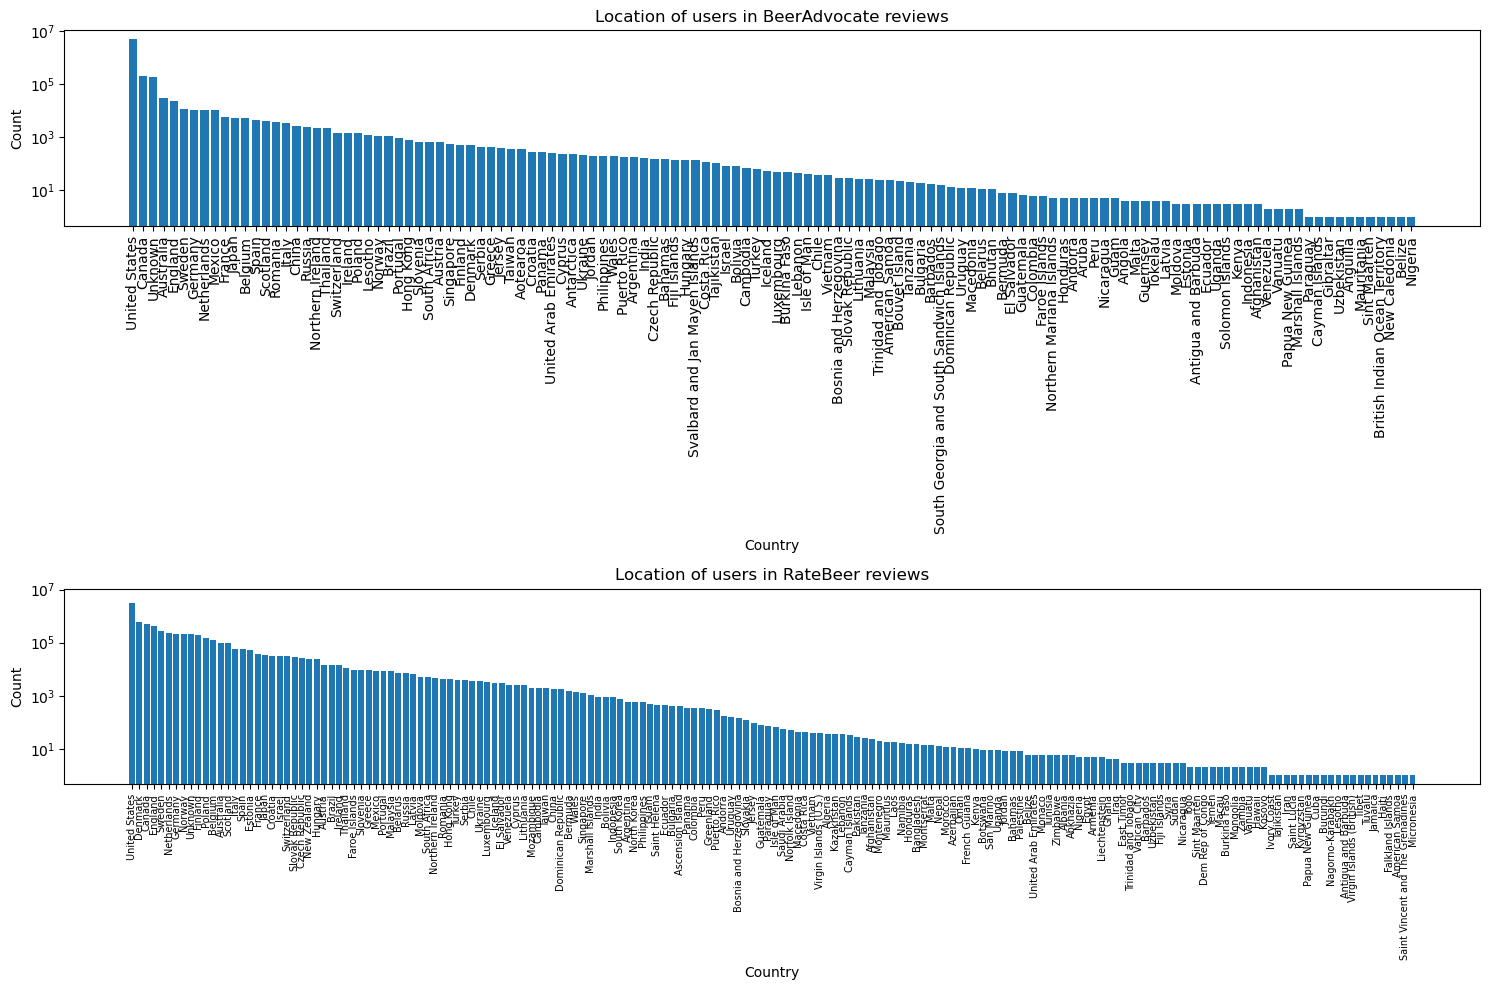

In [56]:
BA_counts_countries_beers = pd.DataFrame(df_BA_reviews['user_merged_location'].value_counts())
BA_counts_countries_beers.reset_index(inplace=True)

RB_counts_countries_beers = pd.DataFrame(df_RB_reviews['user_merged_location'].value_counts())
RB_counts_countries_beers.reset_index(inplace=True)

fig, axes = plt.subplots(2,1, figsize=(15,10), sharey=True)

axes[0].bar(x = BA_counts_countries_beers['index'], height= BA_counts_countries_beers['user_merged_location'])
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[0].set_title('Location of users in BeerAdvocate reviews')

axes[1].bar(x = RB_counts_countries_beers['index'], height= RB_counts_countries_beers['user_merged_location'])
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', labelrotation = 90, labelsize=7)
axes[1].set_title('Location of users in RateBeer reviews')

for ax in axes.flat:
    ax.set(xlabel='Country', ylabel='Count')

fig.tight_layout()


In [57]:
print('Top 10 locations with most users in BeerAdvocate:')
display(BA_counts_countries_beers.head(10))

Top 10 locations with most users in BeerAdvocate:


,index,user_merged_location
0,United States,4983087
1,Canada,197379
2,Unknown,183554
3,Australia,30688
4,England,22825
5,Sweden,11369
6,Germany,11003
7,Netherlands,10517
8,Mexico,10389
9,France,5994


In [58]:
print('Top 10 locations with most users in RateBeer:')
display(RB_counts_countries_beers.head(10))

Top 10 locations with most users in RateBeer:


,index,user_merged_location
0,United States,3109238
1,Denmark,582506
2,Canada,525054
3,England,441710
4,Sweden,283585
5,Netherlands,233852
6,Germany,218881
7,Norway,217063
8,Unknown,203878
9,Finland,192014


So most of the reviews are from users in the United States for both websites. And we also find Canada, Germany Sweden and England in both top 10 locations. <br>
Interestingly, the country that comes second in reviewing beers in the RateBeer website is Denmark.

### Locations of the reviewed breweries

Now let's take a look where are the breweries of the beers that have been rated. **Note that the y axis is in logarithmic scale: it represents orders of magnitude**

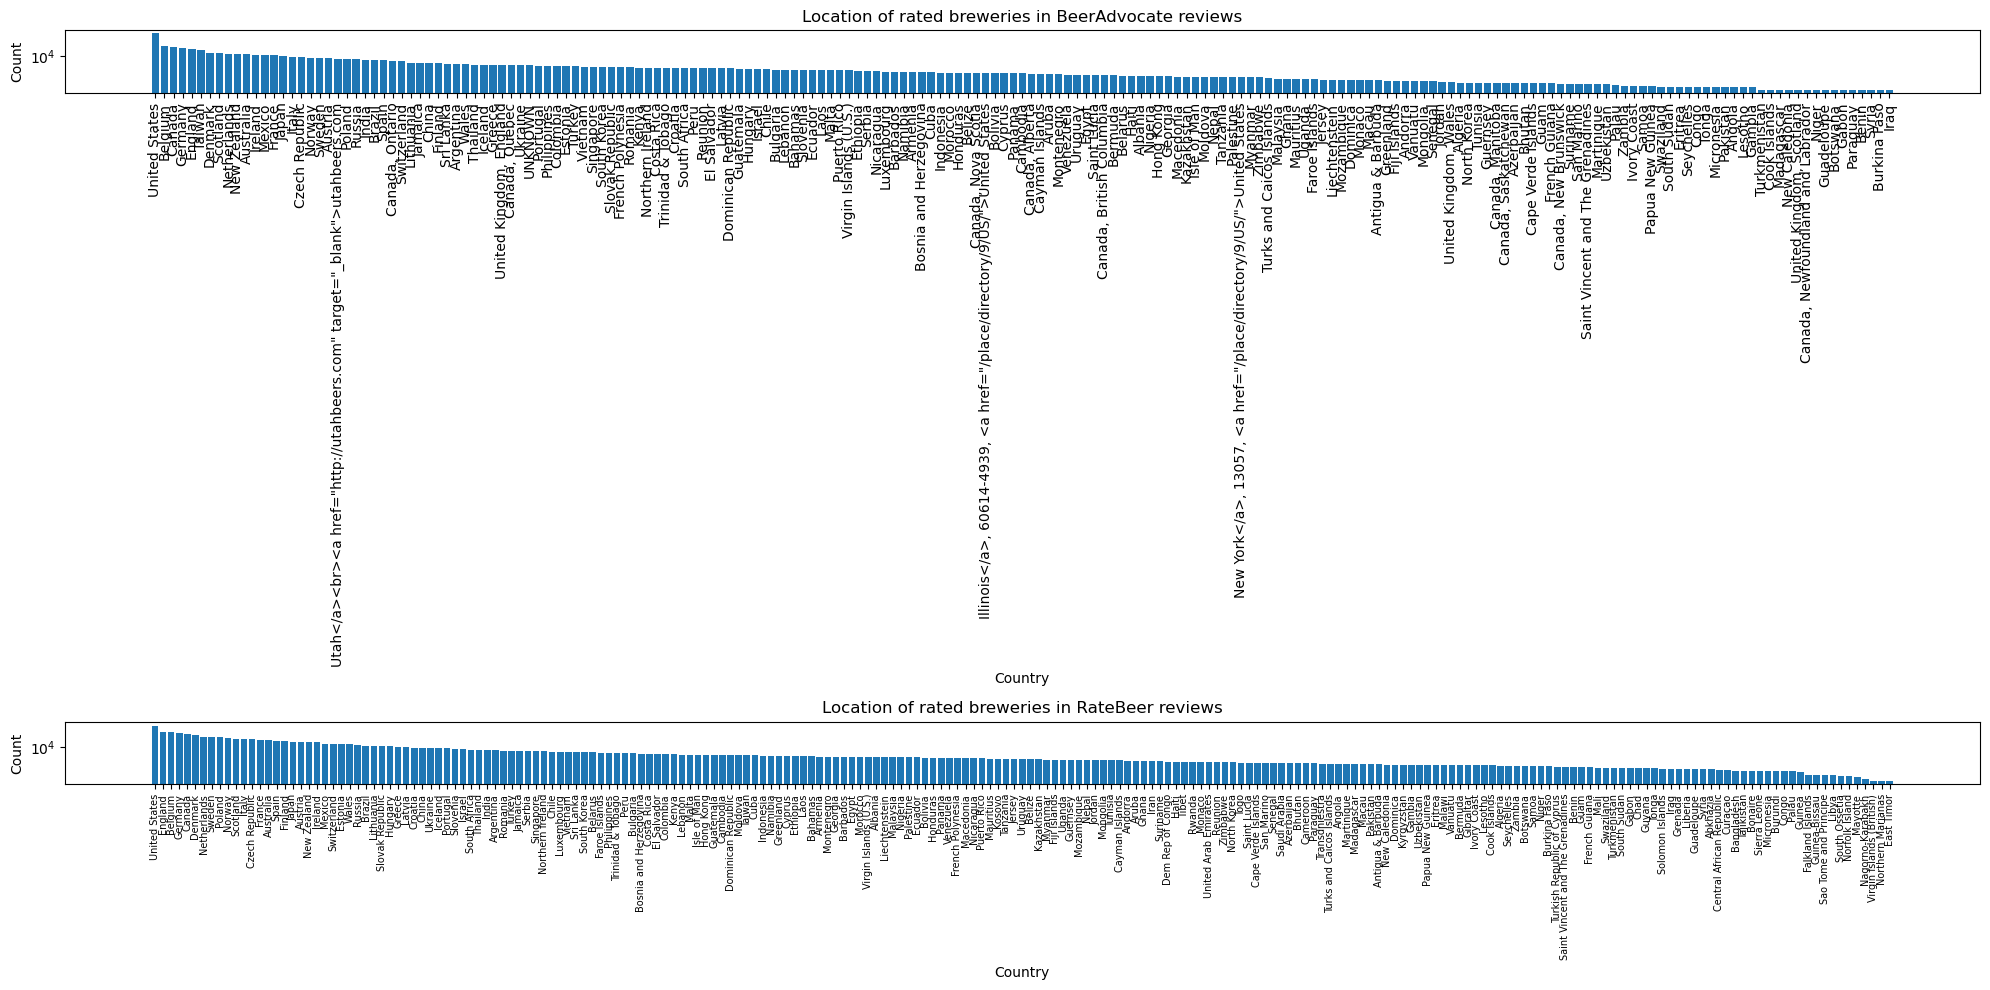

In [87]:
BA_counts_countries_breweries = pd.DataFrame(df_BA_reviews['brewery_merged_location'].value_counts())
BA_counts_countries_breweries.reset_index(inplace=True)

RB_counts_countries_breweries = pd.DataFrame(df_RB_reviews['brewery_merged_location'].value_counts())
RB_counts_countries_breweries.reset_index(inplace=True)

fig, axes = plt.subplots(2,1, figsize=(20,10), sharey=True)

axes[0].bar(x = BA_counts_countries_breweries['index'], height= BA_counts_countries_breweries['brewery_merged_location'])
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[0].set_title('Location of rated breweries in BeerAdvocate reviews')

axes[1].bar(x = RB_counts_countries_breweries['index'], height= RB_counts_countries_breweries['brewery_merged_location'])
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', labelrotation = 90, labelsize=7)
axes[1].set_title('Location of rated breweries in RateBeer reviews')

for ax in axes.flat:
    ax.set(xlabel='Country', ylabel='Count')

fig.tight_layout()

In [88]:
print('Top 10 locations of beers rated in BeerAdvocate:')
display(BA_counts_countries_breweries.head(10))

Top 10 locations of beers rated in BeerAdvocate:


,index,brewery_merged_location
0,United States,4790062
1,Belgium,159917
2,Canada,119992
3,Germany,87747
4,England,71365
5,Taiwan,52937
6,Denmark,24124
7,Scotland,24089
8,Netherlands,17751
9,New Zealand,17038


In [89]:
print('Top 10 locations of beers rated in RateBeer:')
display(RB_counts_countries_breweries.head(10))

Top 10 locations of beers rated in RateBeer:


,index,brewery_merged_location
0,United States,3013577
1,England,646503
2,Belgium,629429
3,Germany,497580
4,Canada,334856
5,Denmark,263815
6,Netherlands,184015
7,Sweden,162142
8,Poland,151208
9,Norway,131294


Now let's look at some of the factors that may influence a beer's liking:

### Most reviewed beer styles

In [95]:
BA_counts_beerstyles = pd.DataFrame(df_BA_reviews['style'].value_counts())
BA_counts_beerstyles.reset_index(inplace=True)

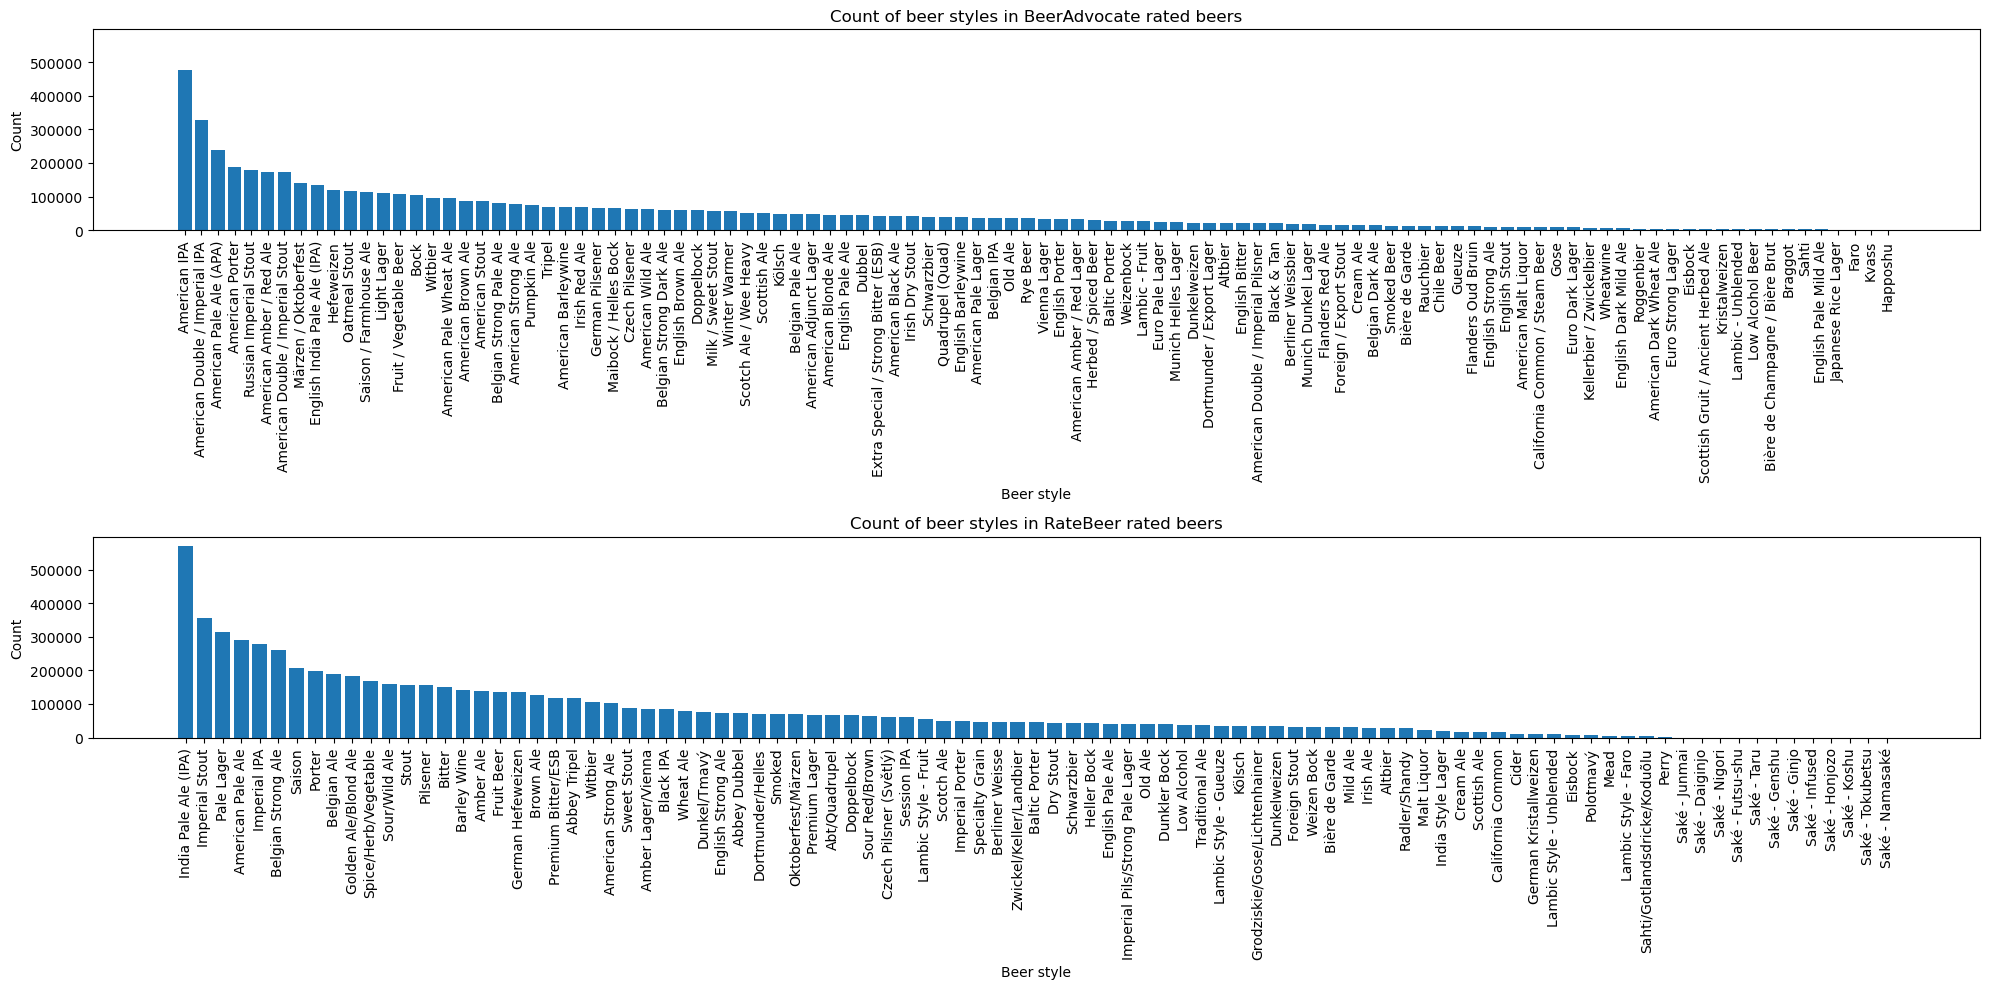

In [111]:
BA_counts_beerstyles = pd.DataFrame(df_BA_reviews['style'].value_counts())
BA_counts_beerstyles.reset_index(inplace=True)

RB_counts_beerstyles= pd.DataFrame(df_RB_reviews['style'].value_counts())
RB_counts_beerstyles.reset_index(inplace=True)

fig, axes = plt.subplots(2,1, figsize=(20,10), sharey=True)

axes[0].bar(x = BA_counts_beerstyles['index'], height= BA_counts_beerstyles['style'])
axes[0].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[0].set_title('Count of beer styles in BeerAdvocate rated beers')

axes[1].bar(x = RB_counts_beerstyles['index'], height= RB_counts_beerstyles['style'])
axes[1].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[1].set_title('Count of beer styles in RateBeer rated beers')

for ax in axes.flat:
    ax.set(xlabel='Beer style', ylabel='Count')

fig.tight_layout()

In [148]:
print('10 most rated beer styles in BeerAdvocate:')
display(BA_counts_beerstyles.head(10))

10 most rated beer styles in BeerAdvocate:


,index,style
0,American IPA,476266
1,American Double / Imperial IPA,328741
2,American Pale Ale (APA),239882
3,American Porter,187770
4,Russian Imperial Stout,180426
5,American Amber / Red Ale,172989
6,American Double / Imperial Stout,172218
7,Märzen / Oktoberfest,141660
8,English India Pale Ale (IPA),135805
9,Hefeweizen,118767


In [149]:
print('10 most rated beer styles in Ratebeer:')
display(RB_counts_beerstyles.head(10))

10 most rated beer styles in Ratebeer:


,index,style
0,India Pale Ale (IPA),569252
1,Imperial Stout,357125
2,Pale Lager,314360
3,American Pale Ale,291303
4,Imperial IPA,277944
5,Belgian Strong Ale,259439
6,Saison,206645
7,Porter,197759
8,Belgian Ale,188404
9,Golden Ale/Blond Ale,182536


Among the most reviewed beer styles across both websites are IPA and its variations.

### Distribution of ratings across websites

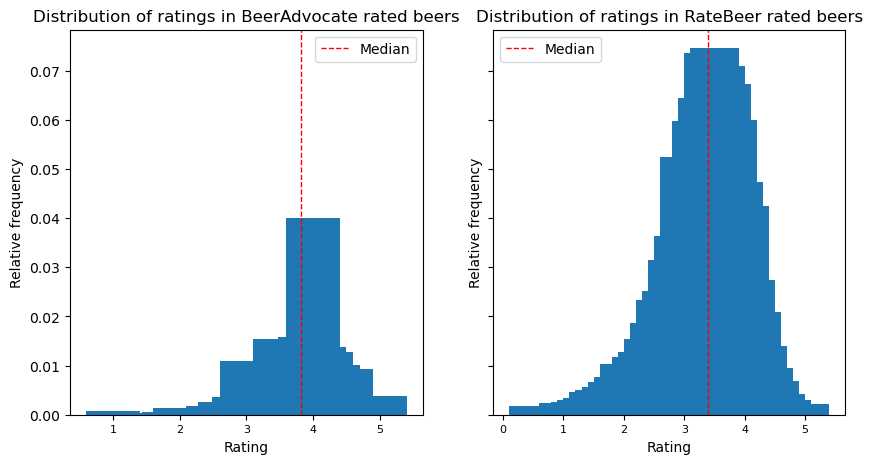

In [145]:
BA_ratings_count = pd.DataFrame(df_BA_reviews['rating'].value_counts(normalize= True))
BA_ratings_count.reset_index(inplace=True)

RB_ratings_count = pd.DataFrame(df_RB_reviews['rating'].value_counts(normalize= True))
RB_ratings_count.reset_index(inplace=True)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey= True)

med_BA = df_BA_reviews['rating'].median()
axes[0].bar(x = BA_ratings_count['index'], height= BA_ratings_count['rating'])
axes[0].tick_params(axis='x', labelrotation = 0, labelsize=8)
axes[0].axvline(x = med_BA, color = 'r', linestyle = 'dashed', linewidth = 1, label='Median')
axes[0].legend()
axes[0].set_title('Distribution of ratings in BeerAdvocate rated beers')

med_RB = df_RB_reviews['rating'].median()
axes[1].bar(x = RB_ratings_count['index'], height= RB_ratings_count['rating'])
axes[1].tick_params(axis='x', labelsize=8)
axes[1].axvline(x = med_RB, color = 'r', linestyle = 'dashed', linewidth = 1, label='Median')
axes[1].legend()
axes[1].set_title('Distribution of ratings in RateBeer rated beers')

for ax in axes.flat:
    ax.set(xlabel='Rating', ylabel='Relative frequency')


We observe visually similar shapes in the distribution (no abormal right or left skewing) with median values of 3.82 and 3.4 for BeerAdvocate and Ratebeer, respectively. 

## Sensorial evaluation  <a class="anchor" id="sensory"></a>

## Location bias  <a class="anchor" id="location"></a>

## Political/Economic climate effect  <a class="anchor" id="political"></a>

***Used DataFrames***

In [15]:
'''
#Stores only the reviews done by users from the US:
df_US_reviews = df_reviews_all[df_reviews_all['user_merged_location'] == 'United States']
df_US_reviews['date'] = pd.to_datetime(df_US_reviews['date'], format="%Y-%m-%d %H:%M:%S")

df_US_reviews['year'] = df_US_reviews['date'].dt.year
df_US_reviews['month_year'] = df_US_reviews['date'].dt.to_period('M')

#Important for the division later on (to obtain the ratio of reviews per month)
df_US_reviews = df_US_reviews.sort_values('date', ascending=True)

df_US_reviews.to_csv(PATH+'/DataframeStorage/df_US_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location', 'year', 'month_year'], index=False)
'''

In [ ]:
df_US_reviews = pd.read_csv(PATH+'/DataframeStorage/df_US_reviews.csv')

### Influence of the financial crisis in 2007/2008 on the appearance of price related words in the ratings.


The general idea is to look whether the price plays a more important role during economically difficult times (which we expect to do). <br>
The approach is to find the text reviews mentionning any price related words and see whether the frequency increased after the onset of the crisis.

First we define the words that we want the text reviews to scan for. <br>

In [12]:
price_related_words = ['price','cheap','expensive', 'inexpensive', 'cost', 'money', 'costly', 'pricey']

In the following cell we have the algorithm extracting the indices for the reviews where the words are mentionned. <br>
We run the algorithm only once and save the list of indices as a pickle that we can open easily.

In [13]:
'''
index_price = []
k = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"


for index, row in df_US_reviews.iterrows():
    #extract the text
    text = str(row['text'])
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in price_related_words]) > 0):
        index_price.append(index)


with open("../DataframeStorage/index_price.bin", "wb") as output:
    pickle.dump(index_price, output)
'''

'\nindex_price = []\nk = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"\n\n\nfor index, row in df_US_reviews.iterrows():\n    #extract the text\n    text = str(row[\'text\'])\n    #split the text into words\n    words = text.split(\' \')\n    #remove all characters that arent letters\n    for i, word in enumerate(words):\n        words[i] = "".join(list(filter(lambda x: x in k, word)))\n    #Check whether a word related to "can" is in the text\n    if (len([x for x in words if x in price_related_words]) > 0):\n        index_price.append(index)\n\n\nwith open("../DataframeStorage/index_price.bin", "wb") as output:\n    pickle.dump(index_price, output)\n'

Open the pickle as a list:

In [14]:
with open("../DataframeStorage/index_price.bin", "rb") as data:
    index_price = pickle.load(data)

First we will see how many reviews mention a price:

In [16]:
print(str(len(index_price)) + ' of the reviews mention prices')

189545 of the reviews mention prices


We have almost 190'000 american reviews mentionning price related words.

In [40]:
df_price_related = df_US_reviews.loc[index_price]


In [43]:
#init_dataframe
df_price_related = df_US_reviews.loc[index_price]
#Important for the division later on (to obtain the ratio of reviews per month)
#Maybe the sorting is not required
df_price_related = df_price_related.sort_values('date', ascending=True)

df_price_related.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location,year,month_year
1320566,Ommegang (Abbey Ale),142,Brewery Ommegang,42,Dubbel,8.2,1998-02-18 11:00:00,Todd,todd.2,4.0,...,4.5,4.5,4.3,Presentation: A beautiful 750ml. bottle with t...,"United States, New York",United States,"United States, California",United States,1998,1998-02
1320566,Ommegang (Abbey Ale),142,Brewery Ommegang,42,Dubbel,8.2,1998-02-18 11:00:00,Todd,todd.2,4.0,...,4.5,4.5,4.3,Presentation: A beautiful 750ml. bottle with t...,"United States, New York",United States,"United States, California",United States,1998,1998-02


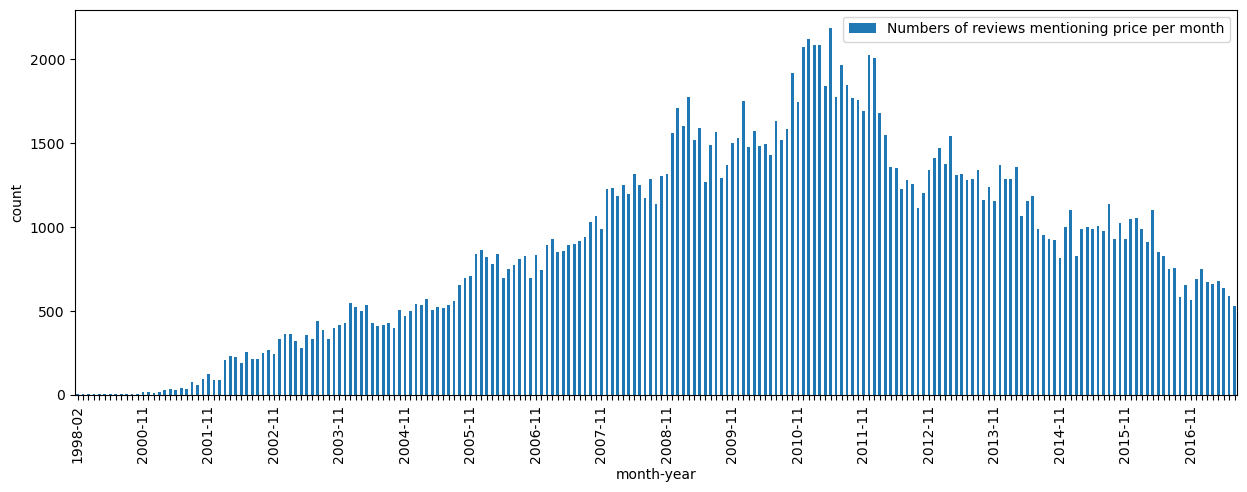

In [26]:
counts_price_reviews = df_price_related.groupby('month_year').count().reset_index()

axes = counts_price_reviews.plot.bar(x = 'month_year', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('month-year')
axes.legend(['Numbers of reviews mentioning price per month'])

for i, t in enumerate(axes.get_xticklabels()):
    if (i % 12) != 0:
        t.set_visible(False)

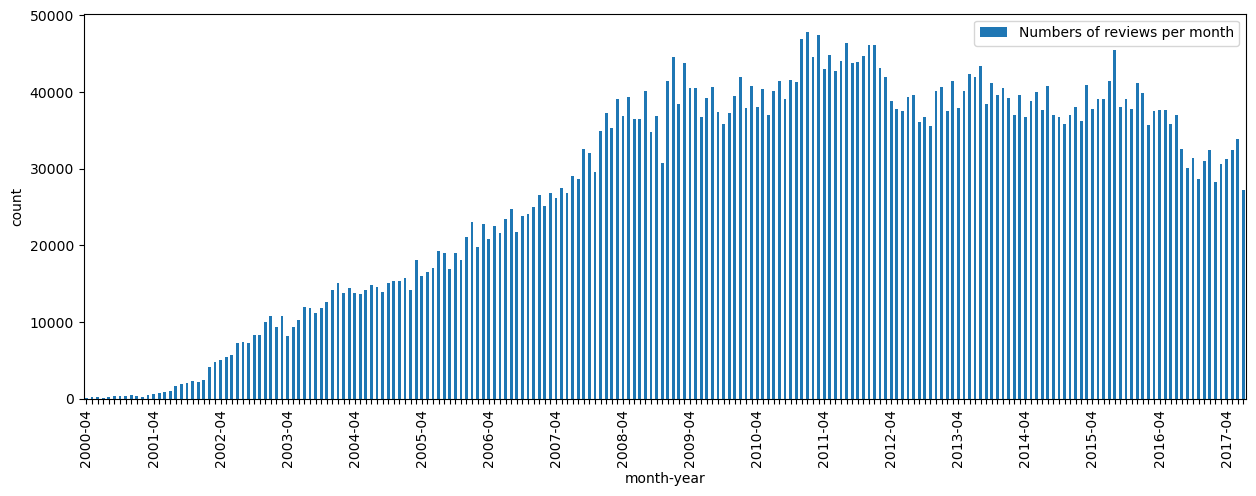

In [65]:
counts_US_reviews = df_US_reviews.groupby('month_year').count().reset_index()

counts_US_reviews = counts_US_reviews[counts_US_reviews['beer_name']>50]

axes = counts_US_reviews.plot.bar(x = 'month_year', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('month-year')
axes.legend(['Numbers of reviews per month'])

for i, t in enumerate(axes.get_xticklabels()):
    if (i % 12) != 0:
        t.set_visible(False)

In [66]:
df_calculation_price_related = counts_price_reviews[['month_year', 'beer_name']]
df_calculation_US_reviews = counts_US_reviews[['month_year', 'beer_name']]

In [67]:
df_calculation = df_calculation_price_related.merge(df_calculation_US_reviews, on='month_year')
df_calculation.rename(columns = {'beer_name_x':'price_related', 'beer_name_y':'all_reviews'}, inplace = True)
df_calculation['ratio'] = (df_calculation['price_related']/df_calculation['all_reviews']*100).round(2)

df_calculation.head(3)

,month_year,price_related,all_reviews,ratio
0,2000-04,2,53,3.77
1,2000-05,4,164,2.44
2,2000-06,5,178,2.81


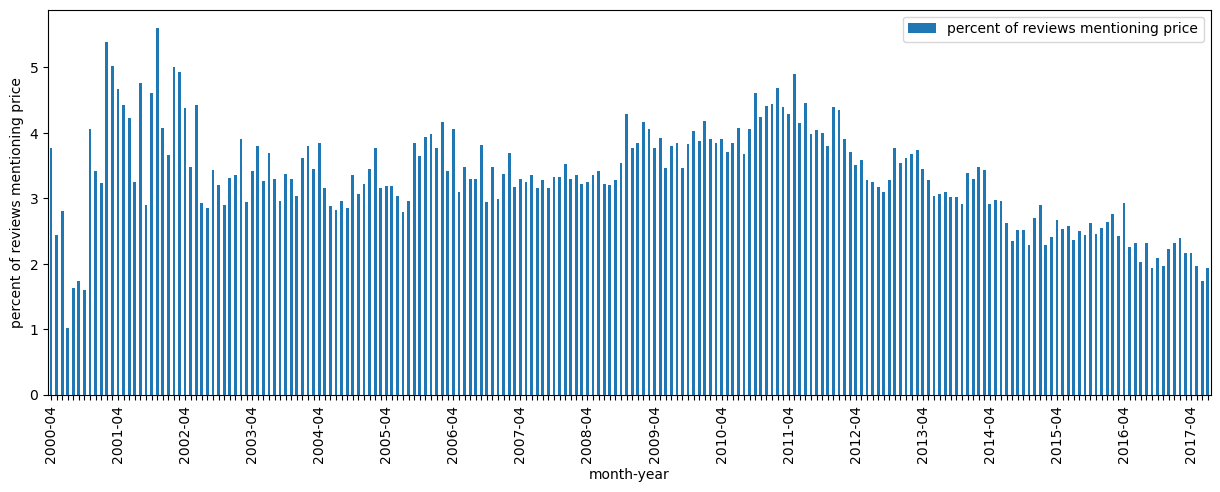

In [68]:
axes = df_calculation.plot.bar(x = 'month_year', y='ratio', figsize=(15,5))
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('month-year')
axes.legend(['percent of reviews mentioning price'])

for i, t in enumerate(axes.get_xticklabels()):
    if (i % 12) != 0:
        t.set_visible(False)

In [59]:
counts_US_reviews.head(37)
test = counts_US_reviews[counts_US_reviews['beer_name']<50]

In [61]:
len(test)

27